In [1]:
import pandas as pd
import json
import os
from IPython.display import display
import sys
sys.path.append("../traffic_generator")
sys.path.append("../interference_injection")
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import json
import os

def load_and_merge_test_data(test_ids, max_time_diff="30s"):
    merged_dfs = []

    for test_id in test_ids:
        print(f"\n===== Test ID: {test_id} =====")
        
        # === Determine source folder for JSONL based on test ID ===
        if "naive" in test_id:
            log_folder = "./naive_logs"
        elif "marla" in test_id:
            log_folder = "./marla_logs"
        else:
            print(f"Unknown strategy in test_id: {test_id}. Skipping.")
            continue
        
        # === Paths ===
        csv_path = f"./traffic_generator_csvs/performance_{test_id}.csv"
        jsonl_path = os.path.join(log_folder, f"{test_id}.jsonl")
        
        # === Load CSV ===
        if not os.path.exists(csv_path):
            print(f"CSV not found for {test_id}: {csv_path}")
            continue
        
        df_perf = pd.read_csv(csv_path)
        df_perf["Time"] = pd.to_datetime(df_perf["Time"])
        
        # === Load JSONL ===
        if os.path.exists(jsonl_path):
            with open(jsonl_path, "r") as f:
                records = [json.loads(line.strip()) for line in f if line.strip()]
            df_dist = pd.DataFrame(records)
            df_dist["timestamp"] = pd.to_datetime(df_dist["timestamp"])

            # === Merge by nearest timestamp ===
            df_perf_sorted = df_perf.sort_values("Time").copy()
            df_dist_sorted = df_dist.sort_values("timestamp").copy()

            merged_df = pd.merge_asof(
                df_perf_sorted,
                df_dist_sorted,
                left_on="Time",
                right_on="timestamp",
                direction="nearest",
                tolerance=pd.Timedelta(max_time_diff) if max_time_diff else None
            )

            merged_dfs.append(merged_df)
            print("✔ Merged with replica distribution data.")
        else:
            print("⚠ No distribution data found. Returning only performance metrics.")
            merged_dfs.append(df_perf)

    return merged_dfs


In [3]:
def plot_metric_by_minute(merged_dfs, test_ids, metric="P99_Latency", max_display_value=20, minute_cap=30):
    """
    Plots the selected metric using the 'Minute' column as x-axis.
    
    Args:
        merged_dfs (list of pd.DataFrame): Merged DataFrames from load_and_merge_test_data().
        test_ids (list of str): Corresponding test IDs (for labeling).
        metric (str): The performance metric to plot.
        max_display_value (float): Clip extreme values (e.g., latency spikes).
        minute_cap (int): Max minute to show (typically 30).
    """
    plt.figure(figsize=(12, 6))
    averages = {}

    for df, test_id in zip(merged_dfs, test_ids):
        if df.empty or metric not in df.columns or 'Minute' not in df.columns:
            print(f"Skipping {test_id}: missing 'Minute' or metric column.")
            continue

        df = df.copy()
        df["Minute"] = pd.to_numeric(df["Minute"], errors='coerce')
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        df = df[(df[metric] < max_display_value) & (df["Minute"] <= minute_cap)]

        averages[test_id] = df[metric].mean()
        plt.plot(df["Minute"], df[metric], marker='o', linewidth=2, label=test_id)

    plt.title(f"{metric.replace('_', ' ')} Over 30 Minutes")
    plt.xlabel("Minute")
    plt.ylabel(metric.replace("_", " ") + " (ms)")
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, minute_cap + 1, 2))
    plt.tight_layout()
    plt.show()


    # Create and display table of average values
    avg_df = pd.DataFrame([
        {"Test ID": test_id, f"Avg {metric} (ms)": f"{avg:.3f}"}
        for test_id, avg in averages.items()
    ])
    avg_df = avg_df.sort_values(by=f"Avg {metric} (ms)")
    print("\n=== AVERAGE METRIC TABLE ===")
    display(avg_df)


    if len(averages) >= 2:
        diffs = []
        labels = list(averages.keys())
        for i in range(len(labels)):
            for j in range(i + 1, len(labels)):
                a, b = labels[i], labels[j]
                v1, v2 = averages[a], averages[b]
                percent_diff = abs(v1 - v2) / ((v1 + v2) / 2) * 100
                diffs.append({"Comparison": f"{a} vs {b}", "% Difference": f"{percent_diff:.2f}%"})

        diff_df = pd.DataFrame(diffs)
        print("\n=== % DIFFERENCES BETWEEN AVERAGES ===")
        display(diff_df)



In [4]:
def plot_replica_distribution_combined(merged_dfs, test_ids, minute_cap=30):
    """
    Plots replica distribution over time for all test IDs in one figure.
    One subplot per node (minikube, minikube-m02), with multiple lines (one per controller).

    Args:
        merged_dfs (list of pd.DataFrame): List of merged DataFrames.
        test_ids (list of str): Matching test IDs.
        minute_cap (int): Maximum minute value for the x-axis.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

    for df, test_id in zip(merged_dfs, test_ids):
        if df.empty or "replica_distribution" not in df.columns or "Minute" not in df.columns:
            print(f"Skipping {test_id}: required columns missing.")
            continue

        df = df.copy()
        df["Minute"] = pd.to_numeric(df["Minute"], errors="coerce")
        df = df[df["Minute"] <= minute_cap]

        # Extract replica counts for both nodes from the dict column
        df["replicas_minikube"] = df["replica_distribution"].apply(
            lambda d: d.get("minikube", 0) if isinstance(d, dict) else 0
        )
        df["replicas_minikube_m02"] = df["replica_distribution"].apply(
            lambda d: d.get("minikube-m02", 0) if isinstance(d, dict) else 0
        )

        # Plot for node: minikube
        axes[0].plot(df["Minute"], df["replicas_minikube"],
                     marker='o', linewidth=2, label=test_id)

        # Plot for node: minikube-m02
        axes[1].plot(df["Minute"], df["replicas_minikube_m02"],
                     marker='o', linewidth=2, label=test_id)

    # === Formatting both subplots ===
    axes[0].set_title("minikube")
    axes[0].set_ylabel("Replicas")
    axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_title("minikube-m02")
    axes[1].set_ylabel("Replicas")
    axes[1].set_xlabel("Minute")
    axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].grid(True)
    axes[1].legend()
    for ax in axes:
        ax.set_xticks(range(0, minute_cap + 1, 2))

    fig.suptitle("Replica Distribution Over Time (All Controllers)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_total_replica_usage(merged_dfs, test_ids, minute_cap=30):
    """
    Plots the total number of replicas across all nodes over time.
    Each line corresponds to a different test_id/controller.

    Args:
        merged_dfs (list of pd.DataFrame): List of merged DataFrames.
        test_ids (list of str): Matching test IDs.
        minute_cap (int): Maximum minute value for the x-axis.
    """
    plt.figure(figsize=(12, 5))

    for df, test_id in zip(merged_dfs, test_ids):
        if df.empty or "replica_distribution" not in df.columns or "Minute" not in df.columns:
            print(f"Skipping {test_id}: required columns missing.")
            continue

        df = df.copy()
        df["Minute"] = pd.to_numeric(df["Minute"], errors="coerce")
        df = df[df["Minute"] <= minute_cap]

        # Compute total replicas across all nodes
        df["total_replicas"] = df["replica_distribution"].apply(
            lambda d: sum(d.values()) if isinstance(d, dict) else 0
        )

        plt.plot(df["Minute"], df["total_replicas"],
                 marker='o', linewidth=2, label=test_id)

    plt.title("Total Replica Usage Over Time (All Nodes Combined)")
    plt.xlabel("Minute")
    plt.ylabel("Total Replicas")
    plt.xticks(range(0, minute_cap + 1, 2))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
from config import RPS_30MIN_GRADUAL_WIDE

def plot_rps_schedule(rps_schedule, title="Traffic Load: RPS per Minute"):
    plt.figure(figsize=(12, 4))
    plt.plot(range(len(rps_schedule)), rps_schedule, marker='o')
    plt.xlabel("Minute")
    plt.ylabel("RPS")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Traffic Load

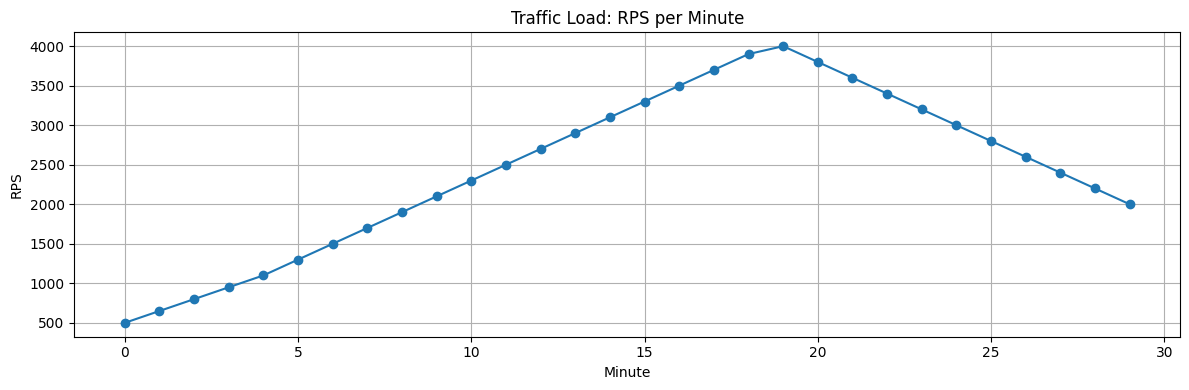

In [7]:
# Example usage
plot_rps_schedule(RPS_30MIN_GRADUAL_WIDE)

## CPU Interference


===== Test ID: cpu2_naive_v10 =====
✔ Merged with replica distribution data.

===== Test ID: cpu2_marla_v21 =====
✔ Merged with replica distribution data.


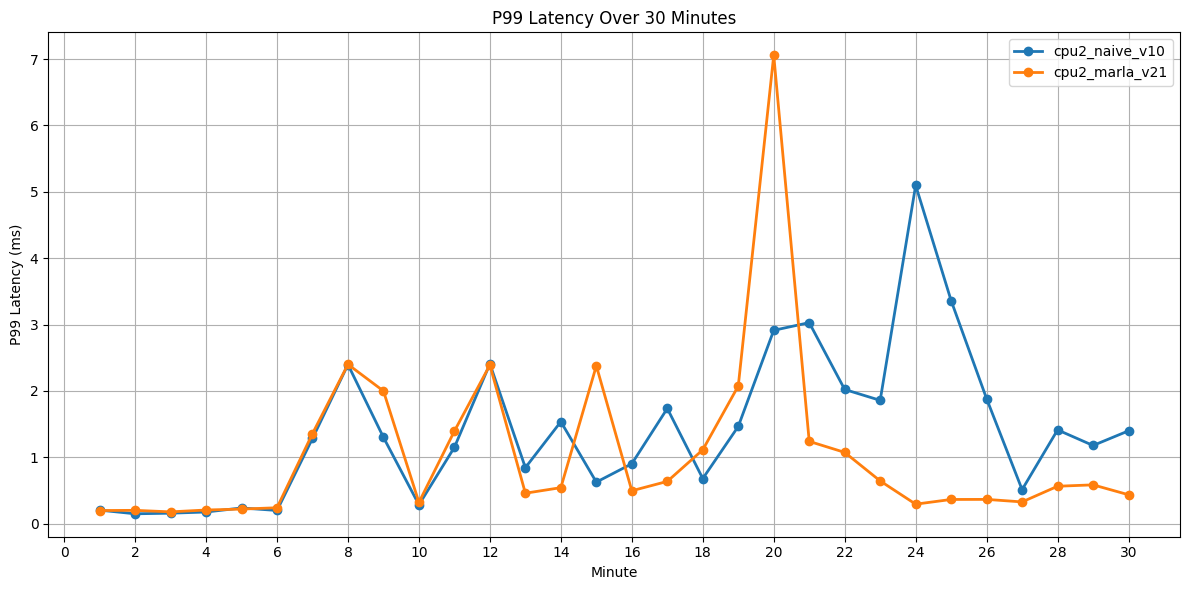


=== AVERAGE METRIC TABLE ===


,Test ID,Avg P99_Latency (ms)
1,cpu2_marla_v21,1.060
0,cpu2_naive_v10,1.415



=== % DIFFERENCES BETWEEN AVERAGES ===


,Comparison,% Difference
0,cpu2_naive_v10 vs cpu2_marla_v21,28.69%


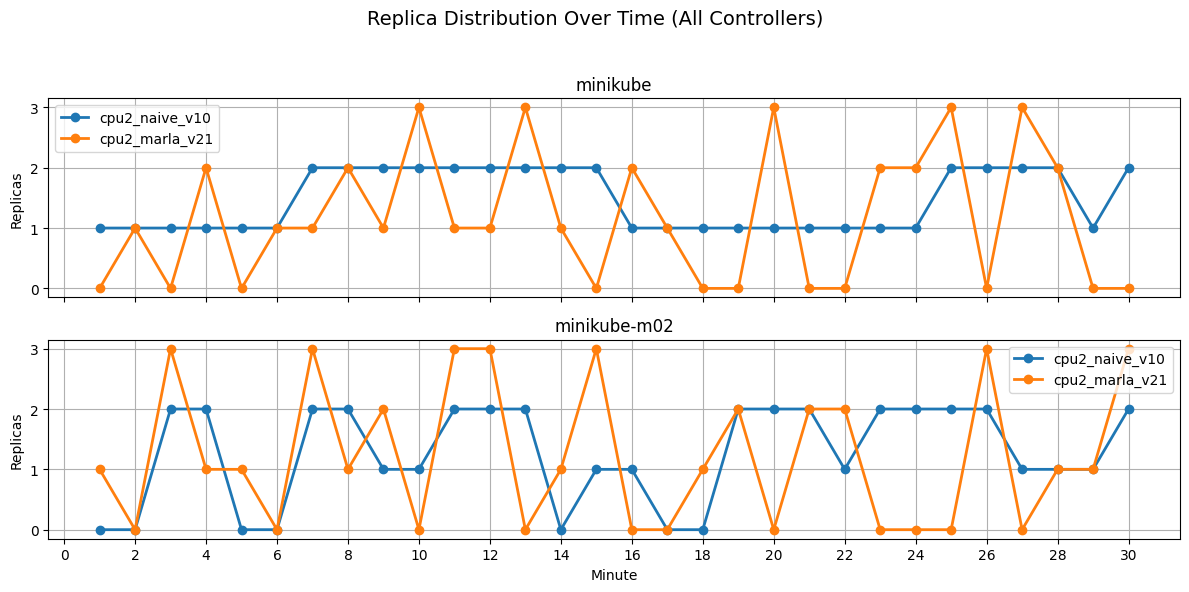

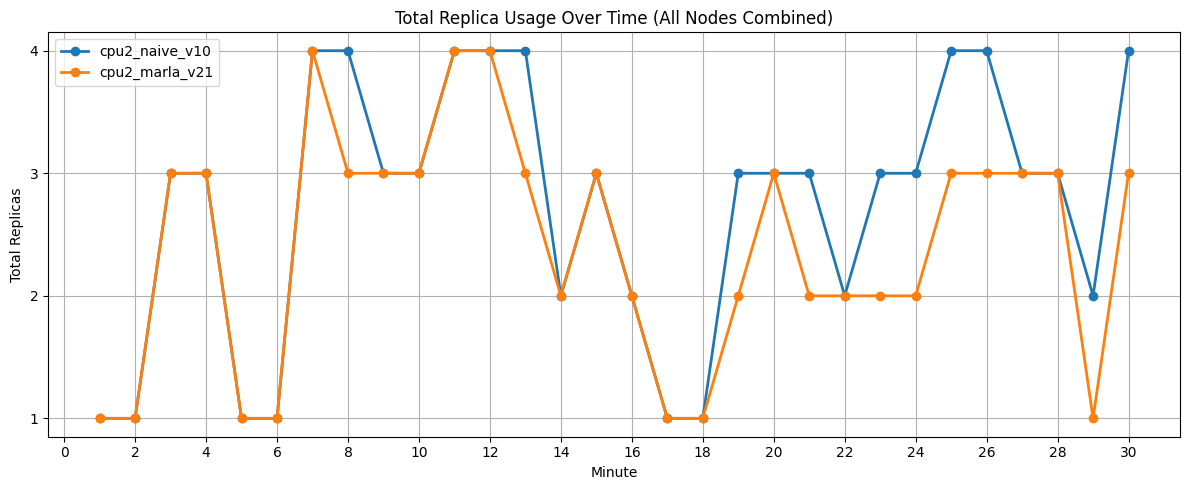

In [8]:
# cpu2_naive_v02 -> always
# cpu2_marla_v02 -> random forest
# cpu2_marla_v04 -> different placement logic (same number of replicas) + random forest
# cpu2_marla_v05 -> xgboost (1500)
# cpu2_marla_v06 -> xgboost (1700)


names = ["cpu2_naive_v10", "cpu2_marla_v21"]
cpu01_dfs = load_and_merge_test_data(names)
plot_metric_by_minute(cpu01_dfs, names, metric="P99_Latency", max_display_value=20)
plot_replica_distribution_combined(cpu01_dfs, names, minute_cap=30)
plot_total_replica_usage(cpu01_dfs, names, minute_cap=30)

## L3 Interference


===== Test ID: l3_as1_naive_v101 =====
✔ Merged with replica distribution data.

===== Test ID: l3_as1_marla_v101 =====
✔ Merged with replica distribution data.


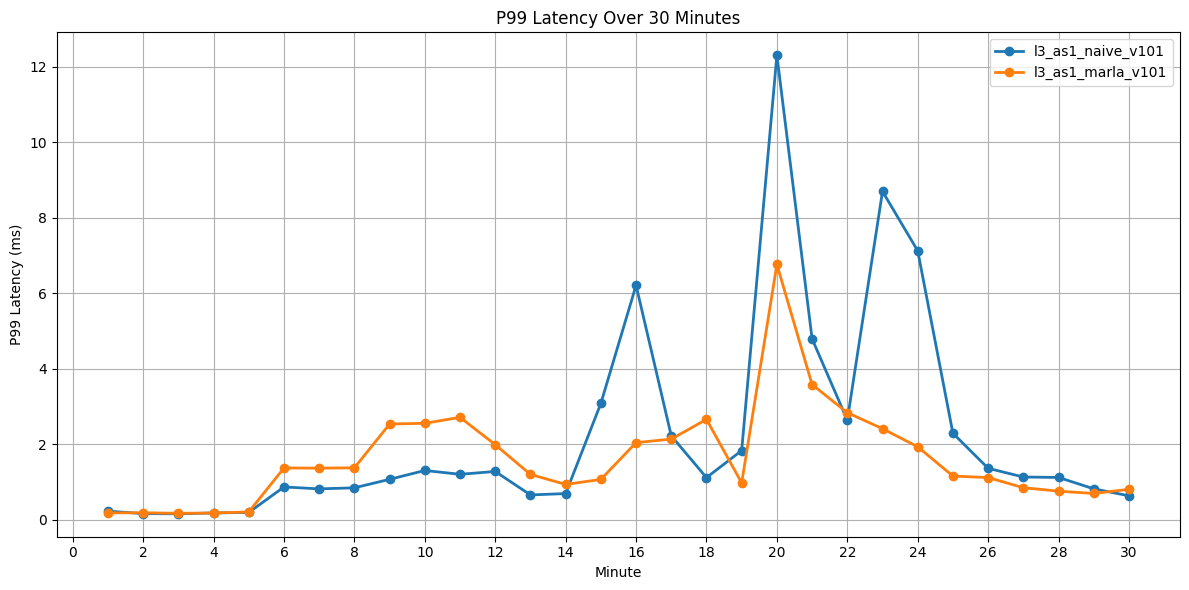


=== AVERAGE METRIC TABLE ===


,Test ID,Avg P99_Latency (ms)
1,l3_as1_marla_v101,1.624
0,l3_as1_naive_v101,2.234



=== % DIFFERENCES BETWEEN AVERAGES ===


,Comparison,% Difference
0,l3_as1_naive_v101 vs l3_as1_marla_v101,31.59%


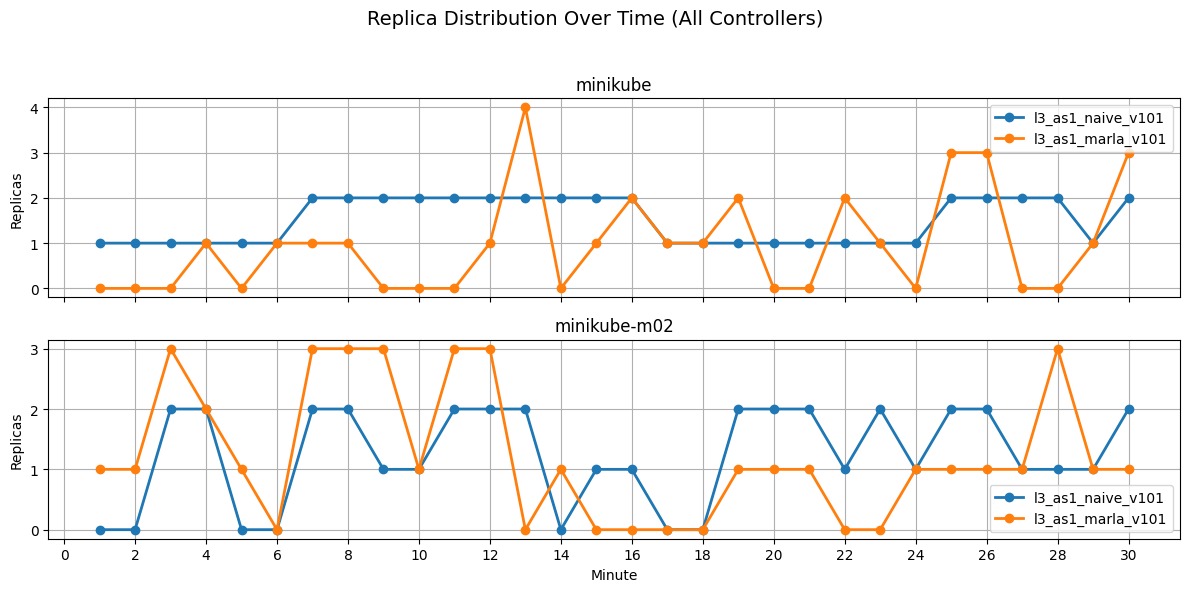

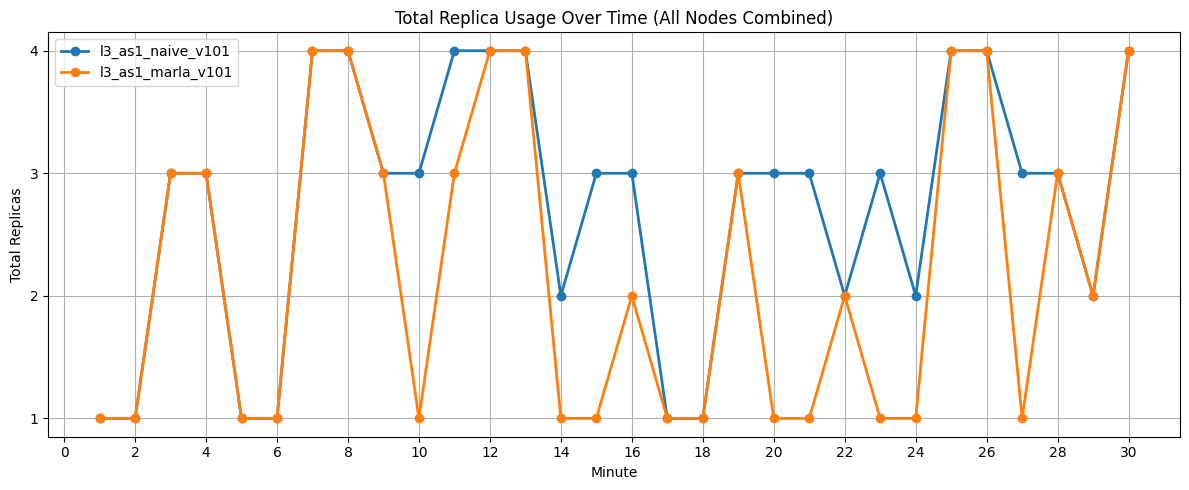

In [8]:
names = ["l3_as1_naive_v101", "l3_as1_marla_v101"]
l3_v01_dfs = load_and_merge_test_data(names)
plot_metric_by_minute(l3_v01_dfs, names, metric="P99_Latency", max_display_value=20)
plot_replica_distribution_combined(l3_v01_dfs, names, minute_cap=30)
plot_total_replica_usage(l3_v01_dfs, names, minute_cap=30)

## MemBw Interference


===== Test ID: membw2_naive_v101 =====
✔ Merged with replica distribution data.

===== Test ID: membw2_marla_v102 =====
✔ Merged with replica distribution data.


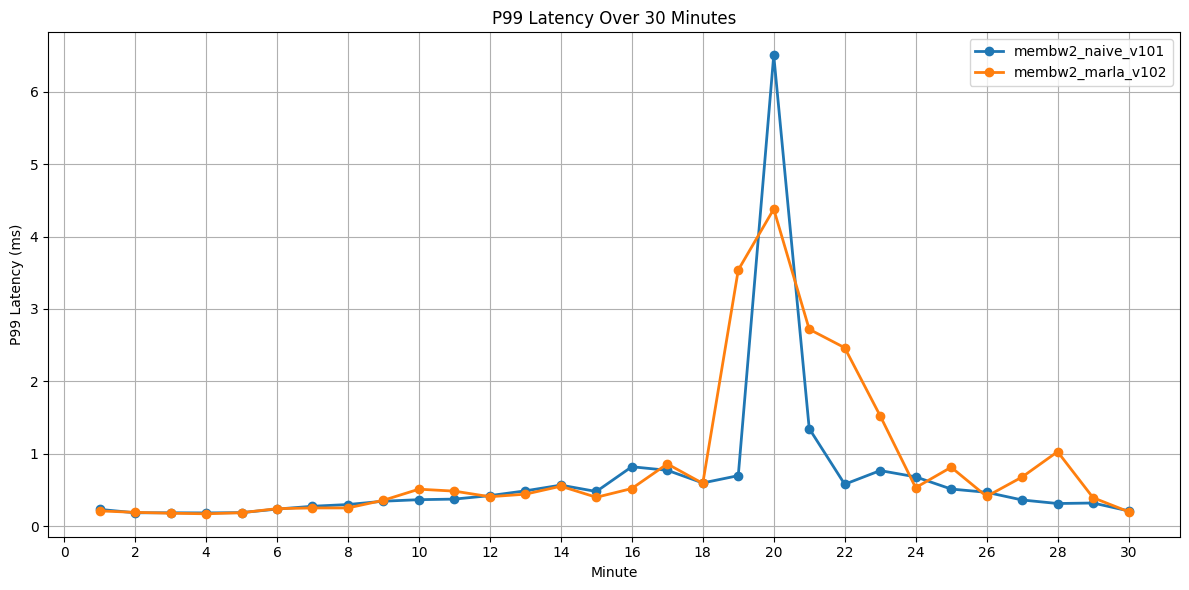


=== AVERAGE METRIC TABLE ===


,Test ID,Avg P99_Latency (ms)
0,membw2_naive_v101,0.659
1,membw2_marla_v102,0.850



=== % DIFFERENCES BETWEEN AVERAGES ===


,Comparison,% Difference
0,membw2_naive_v101 vs membw2_marla_v102,25.25%


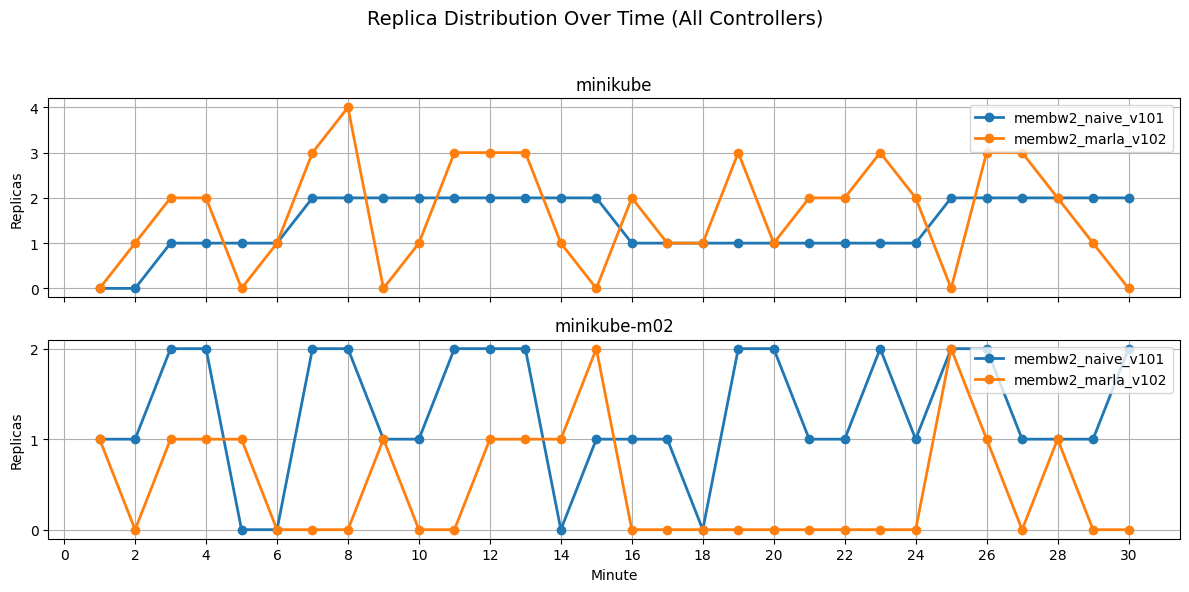

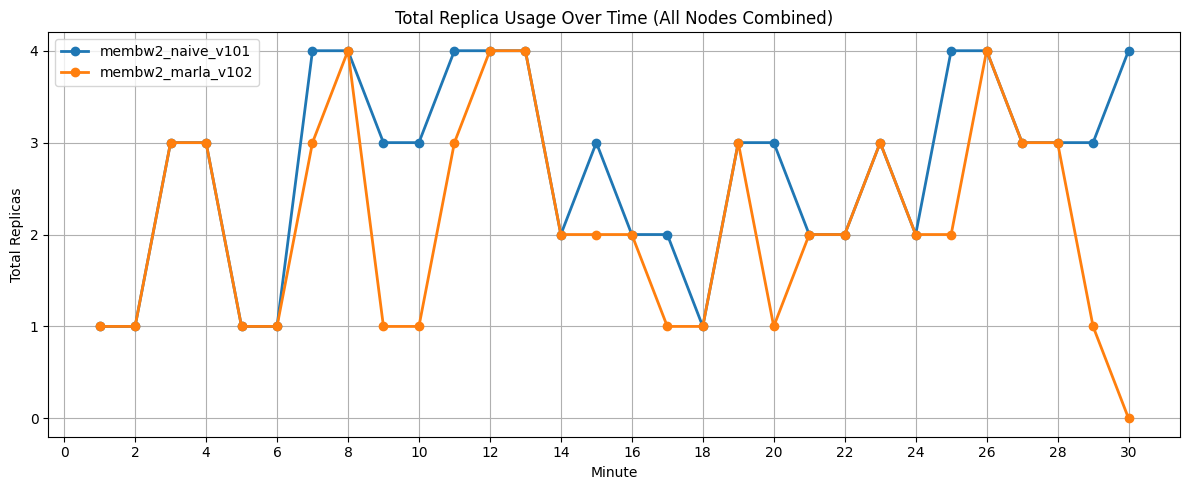

In [13]:
names = ["membw2_naive_v101", "membw2_marla_v102"]
membw_v01_dfs = load_and_merge_test_data(names)
plot_metric_by_minute(membw_v01_dfs,names, metric="P99_Latency", max_display_value=20)
plot_replica_distribution_combined(membw_v01_dfs, names, minute_cap=30)
plot_total_replica_usage(membw_v01_dfs, names, minute_cap=30)

## MIXED Interference


===== Test ID: mixed_as1_naive_v101 =====
✔ Merged with replica distribution data.

===== Test ID: mixed_as1_marla_v102 =====
✔ Merged with replica distribution data.


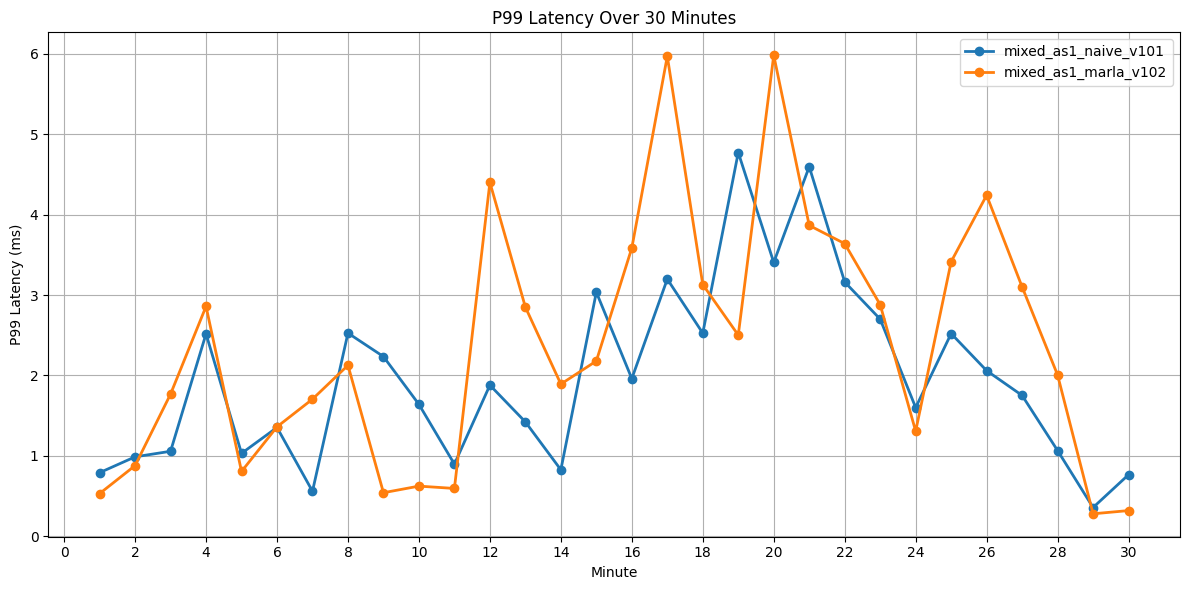


=== AVERAGE METRIC TABLE ===


,Test ID,Avg P99_Latency (ms)
0,mixed_as1_naive_v101,1.974
1,mixed_as1_marla_v102,2.378



=== % DIFFERENCES BETWEEN AVERAGES ===


,Comparison,% Difference
0,mixed_as1_naive_v101 vs mixed_as1_marla_v102,18.59%


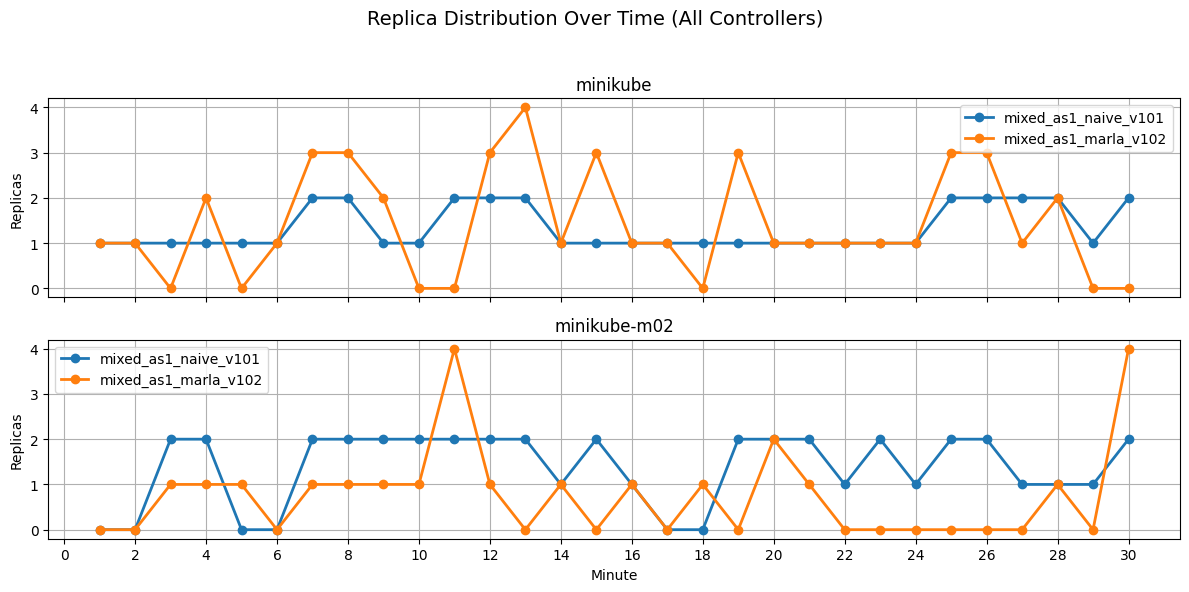

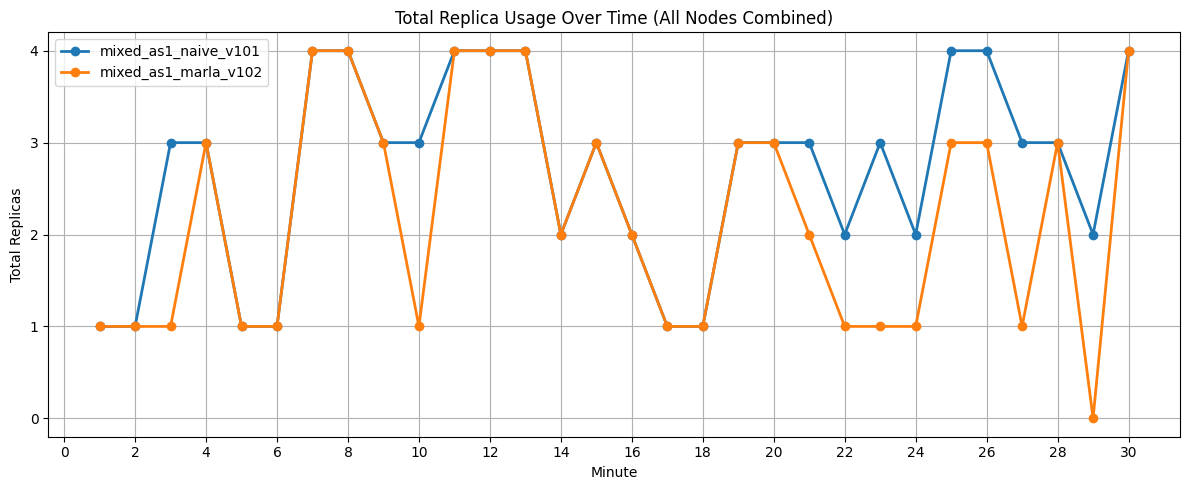

In [12]:
names = ["mixed_as1_naive_v101", "mixed_as1_marla_v102"]
mixed_v01_dfs = load_and_merge_test_data(names)
plot_metric_by_minute(mixed_v01_dfs, names, metric="P99_Latency", max_display_value=20)
plot_replica_distribution_combined(mixed_v01_dfs, names, minute_cap=30)
plot_total_replica_usage(mixed_v01_dfs, names, minute_cap=30)